# Test validity step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee

import non_parametric_ML_compsep as katame

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_SO_128 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 196608)
(6, 2, 196608)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


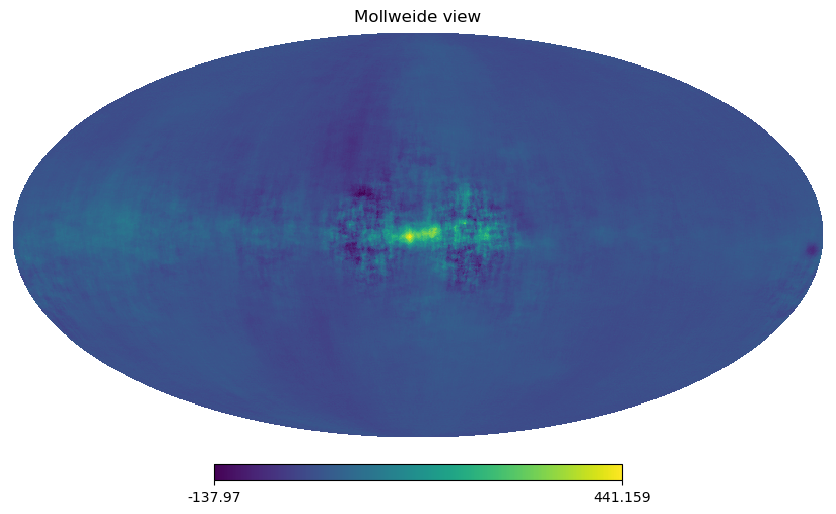

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64*2
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = katame.get_noise_covar(depth_p, nside)
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [8]:
mixing_matrix_sampled

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.21055502e-02, 1.77190420e+00],
       [1.00000000e+00, 5.16775485e-02, 7.56410599e+00],
       [1.00000000e+00, 1.29207310e-01, 1.89122320e+01],
       [1.00000000e+00, 4.40790072e-01, 6.45189820e+01],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [9]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = katame.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 1.35 s, sys: 317 ms, total: 1.66 s
Wall time: 446 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [10]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [11]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  316 iterations !!
CPU times: user 2min 44s, sys: 26.3 s, total: 3min 11s
Wall time: 39.5 s


### Wiener filter part

In [12]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  393 iterations !!
CPU times: user 3min 32s, sys: 36.6 s, total: 4min 9s
Wall time: 43.7 s


In [13]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [14]:
%%time
c_ells_Wishart = katame.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)

red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = katame.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = katame.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)


CPU times: user 581 ms, sys: 165 ms, total: 745 ms
Wall time: 157 ms


## Sampling B_f : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [15]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [16]:
first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

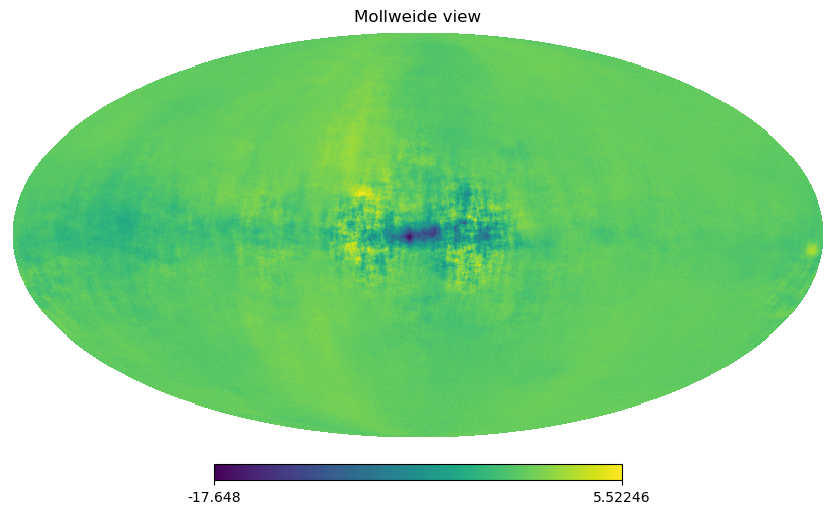

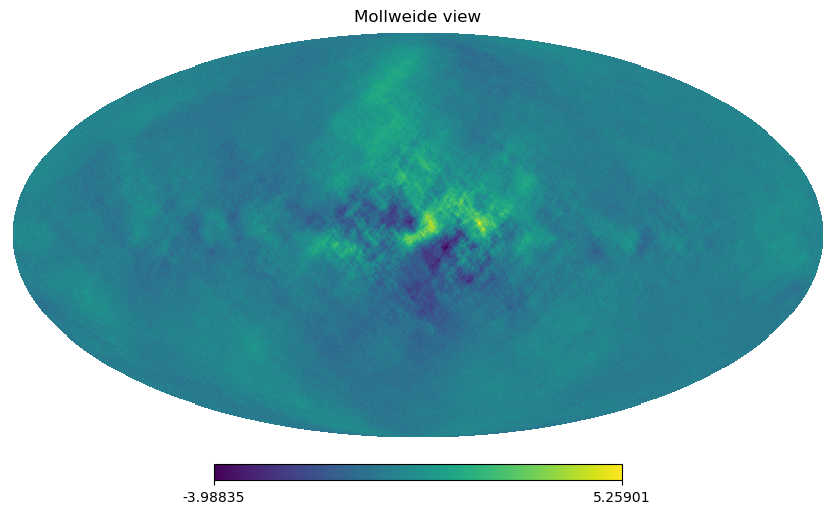

In [17]:
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

In [24]:
print(cp_cp_noise)

[[ 2.05042560e-02 -2.04757472e-02 -4.85864469e-04]
 [-2.04757472e-02  6.96617761e-01 -4.13434409e-03]
 [-4.85864469e-04 -4.13434409e-03  6.12262784e-05]]


In [25]:
# for i in range(6):
#     hp.mollview(freq_maps[i,0])
#     hp.mollview(freq_maps[i,1])

In [26]:
# for i in range(6):
#     hp.mollview(full_data_without_CMB[i,0])
#     hp.mollview(full_data_without_CMB[i,1])

In [27]:
hp.nside2resol(nside)

0.007994739905831941

In [28]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = katame.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = katame.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))

[[0.00000000e+00 1.03664028e-02 2.85137869e+00 4.41822485e+00
  4.20347274e+00 1.47890258e+00]
 [3.08280494e-01 1.51734306e+00 4.17359787e+02 6.46700976e+02
  6.15267447e+02 0.00000000e+00]] (2, 6) (6, 2, 196608)
d-Bcsc -- mean 4.069728085617974 max 606.7877794162583 min -333.7584733242436
B_fN^{-1} (d-Bcsc) - mean 2236.084624938387 max 233082.381075782 min -124031.41644769133
B_fN^{-1} - mean 141.1763481663534 max 646.7009758738561 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean 0.1667452825956491 max 0.6761704830919993 min -0.004619533023581198


In [29]:
# hp.mollview(map_fgs[0,0])
# hp.mollview(map_fgs[0,1])
# hp.mollview(map_fgs[1,0])
# hp.mollview(map_fgs[1,1])

In [30]:
np.log(np.linalg.det(cp_cp_noise))

-15.195100765740232

In [31]:
%%time

# Calculation value log_proba with current value of B_f

regularization_constant = -1
regularization_factor = 10**10
# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", np.exp(log_proba))

CG-Python-0 WF finished in  11 iterations !!
Log_proba : -0.7677771205302133
<-> Proba : 0.4640434353215867
CPU times: user 7.02 s, sys: 1.29 s, total: 8.31 s
Wall time: 1.43 s


In [32]:
%%time
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()

full_initial_guess = np.random.randn(mixing_matrix_obj.params.ravel().shape[0]).reshape(mixing_matrix_obj.params.shape)
param_init = mixing_matrix_obj.params
mixing_matrix_obj.update_params(full_initial_guess)
# Calculation value log_proba with current value of B_f

print('Init values random :', full_initial_guess)
print('True initial values :', param_init)

regularization_constant = -1
regularization_factor = 10**10
# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", np.exp(log_proba))

mixing_matrix_obj.update_params(param_init)


Init values random : [[-0.35660567  0.49673765]
 [-1.61047142  0.59190466]
 [ 0.20691101 -0.35980439]
 [ 1.3555311   0.75965858]]
True initial values : [[1.21055502e-02 1.77190420e+00]
 [5.16775485e-02 7.56410599e+00]
 [1.29207310e-01 1.89122320e+01]
 [4.40790072e-01 6.45189820e+01]]
CG-Python-0 WF finished in  11 iterations !!
Log_proba : -0.931889203642076
<-> Proba : 0.3938090217207167
CPU times: user 7.23 s, sys: 1.33 s, total: 8.56 s
Wall time: 1.33 s


In [33]:
mixing_matrix_obj.params.shape

(4, 2)

In [34]:
ver = '0a'
filename_backend_mcmc = "validation_step_4_SO_{}ver{}.h5".format(nside,ver)
# ver = '0b'
# filename_backend_mcmc = "validation_step_4_ver{}.h5".format(ver)

In [35]:
# %%time
# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# number_steps_sampler = 300
# with_prints = False

# # whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)


# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.25,high=initial_guess_fg_mixing_matrix*.75, size=(n_walkers,dimensions_mixing_matrix))
# # print("Test", full_initial_guess)
# final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# CPU times: user 3h 37min 1s, sys: 1h 10min 14s, total: 4h 47min 15s
# Wall time: 44min 2s


In [37]:
%%time
# And now sampling B_f using emcee

n_walkers = 20
# We have 6*3 parameters to sample, trying to go with 100 steps first
number_steps_sampler = 800
with_prints = False

# whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

backend = emcee.backends.HDFBackend(filename_backend_mcmc)
backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(number_steps_sampler)

# This will be useful to testing convergence
old_tau = np.inf

# Initial guess
# full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.25,high=initial_guess_fg_mixing_matrix*.75, size=(n_walkers,dimensions_mixing_matrix))


# final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# Now we'll sample for up to number_steps_sampler steps
for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
    # Only check convergence every 100 steps
    if sample_params_mixing_matrix_FG.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau


100%|██████████| 800/800 [5:56:55<00:00, 26.77s/it]  

CPU times: user 20h 59min 10s, sys: 9h 43min 59s, total: 1d 6h 43min 10s
Wall time: 5h 57min 33s


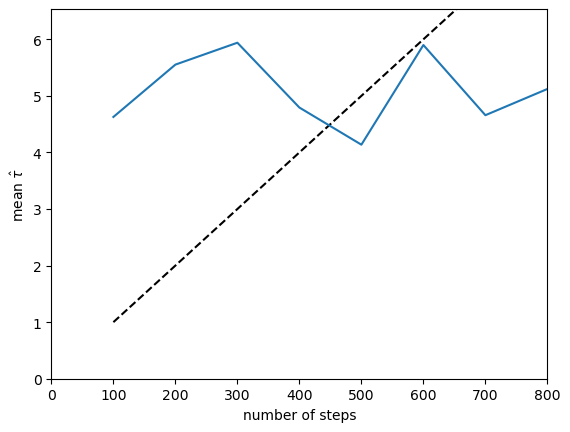

In [38]:
time_array = 100 * np.arange(1, index + 1)
plt.plot(time_array, time_array / 100.0, "--k")
plt.plot(time_array, autocorr[:index])
plt.xlim(0, time_array.max())
plt.ylim(0, autocorr[:index].max() + 0.1 * (autocorr.max() - autocorr.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [39]:
tau = sample_params_mixing_matrix_FG.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sample_params_mixing_matrix_FG.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sample_params_mixing_matrix_FG.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sample_params_mixing_matrix_FG.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))


burn-in: 10
thin: 2
flat chain shape: (7900, 8)
flat log prob shape: (7900,)


AttributeError: 'NoneType' object has no attribute 'shape'

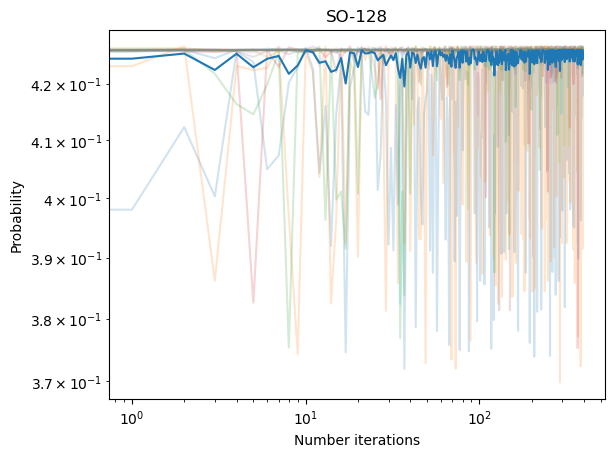

In [64]:
log_prob_samples_reshape = log_prob_samples.reshape((n_walkers, int((number_steps_sampler-burnin)/thin)))

plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.exp(log_prob_samples_reshape.T), alpha=.2)
plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.mean(np.exp(log_prob_samples_reshape.T),axis=1))
plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Probability')
plt.show()

In [41]:
tau

array([5.12183566, 5.12183567, 5.12183567, 5.12183565, 5.12183564,
       5.12183567, 5.12183566, 5.12183567])

In [42]:
whole_chain_samples = sample_params_mixing_matrix_FG.get_chain()

In [43]:
print(whole_chain_samples.shape)

(800, 20, 8)


In [78]:
whole_chain_samples.shape

(800, 20, 8)

In [44]:
whole_chain_samples[-1].mean(axis=0)

array([ 2.82727017e+113, -2.54195524e+115,  9.09728361e+112,
       -1.19895272e+116, -4.22932409e+114, -6.55970531e+116,
        2.29100120e+115,  1.71254759e+117])

In [73]:
whole_chain_samples.mean(axis=(1,2)).shape

(800,)

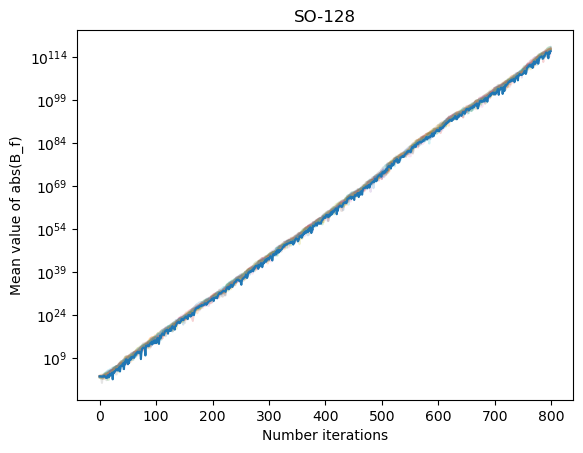

In [79]:
plt.plot(np.arange(number_steps_sampler), np.abs(whole_chain_samples.mean(axis=(2))), alpha=.2)
plt.plot(np.arange(number_steps_sampler), np.abs(whole_chain_samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

In [65]:
print(katame.get_conditional_proba_mixing_matrix_foregrounds(whole_chain_samples[-1].mean(axis=0), mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor))


CG-Python-0 WF finished in  7 iterations !!
-0.8530454627198312


In [69]:
print(katame.get_conditional_proba_mixing_matrix_foregrounds(whole_chain_samples[-1].mean(axis=0)/whole_chain_samples[-1].max(axis=0), mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor))


CG-Python-0 WF finished in  12 iterations !!
-0.9152093984045961


In [68]:
print(katame.get_conditional_proba_mixing_matrix_foregrounds(initial_guess_fg_mixing_matrix, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor))

CG-Python-0 WF finished in  11 iterations !!
-0.8640944887945856


In [ ]:
autocorr_time = sample_params_mixing_matrix_FG.get_autocorr_time()

print(autocorr_time.shape)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [4.92166271 6.04822622 5.94470766 5.91877733 5.90582456 5.93614202
 5.83141322 5.92395121]

In [ ]:
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)